In [1]:
import pandas as pd
import numpy as np
import re
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split


In [2]:
data = pd.read_csv('SQL_Dataset.csv')
data.head()

,Query,Label
0,""" or pg_sleep ( __TIME__ ) --",1
1,create user name identified by pass123 tempora...,1
2,AND 1 = utl_inaddr.get_host_address ( ...,1
3,select * from users where id = '1' or @ @1 ...,1
4,"select * from users where id = 1 or 1#"" ( ...",1


In [3]:
data.shape

(30919, 2)

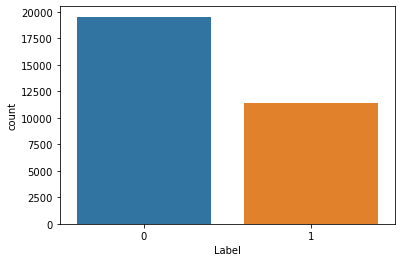

In [4]:
#checking if the data is balanced or not
#reference: https://www.geeksforgeeks.org/countplot-using-seaborn-in-python/
sns.countplot(x = 'Label', data = data)
plt.show()

There are more non-malicious queries than malicious queries. Before performing feature extraction and further EDA, we will have to split the data into train and test data, and perform further analysis on the train data. We will have to perform startified split to ensure the proportions of malicious and non-malicious queries is same in train and test data.

In [5]:
X = data['Query']
y = data['Label']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.25, stratify = y, random_state = 42)
print(X_train.shape)
print(X_test.shape)

(23189,)
(7730,)


There are few data cleanup tasks that have to be done.
1. converting all characters in the query to lower case.
2. checking for missing values.
3. removing duplicates in the data.

In [6]:
X_train.head()

7768     1%' and 6055  =  ctxsys.drithsx.sn  (  6055,  ...
14655                                        piedramillera
19535    SELECT wp_posts.* FROM wp_posts WHERE ID IN  (...
2239     select count  (  *  )   from domain.domains as...
10007    call regexp_substring  (  repeat  (  left  (  ...
Name: Query, dtype: object

In [7]:
#converting to lower case
def to_lower_case(x):
    
    return x.lower()

X_train = X_train.apply(to_lower_case)
X_train.head()

7768     1%' and 6055  =  ctxsys.drithsx.sn  (  6055,  ...
14655                                        piedramillera
19535    select wp_posts.* from wp_posts where id in  (...
2239     select count  (  *  )   from domain.domains as...
10007    call regexp_substring  (  repeat  (  left  (  ...
Name: Query, dtype: object

In [8]:
#checking for missing values
np.sum(pd.isnull(X_train))

0

Therefore, there are no missing values to be taken care of.

In [9]:
#checking for duplicates
df = pd.concat([X_train, y_train], axis = 1)
df.shape

(23189, 2)

In [10]:
df.columns

Index(['Query', 'Label'], dtype='object')

In [11]:
df[df.duplicated(subset = ['Query', 'Label'])]

,Query,Label
581,union select,1
18233,#name?,0
18350,7.75e+15,0
700,union select,1
377,x' and members.email is null; --,1
19332,29%,1
15635,#name?,0
19328,26%,1
723,x' and email is null; --,1
362,x' and userid is null; --,1


In [12]:
#Now we will drop all the duplicates.
df.drop_duplicates(subset = ['Query', 'Label'], inplace = True)
df.shape

(23175, 2)

In [13]:
#checking for duplicate queries having different label values 
df[df.duplicated(subset = ['Query'], keep = False)]

,Query,Label
13532,#name?,0
17499,1,0
4244,1,1
656,#name?,1


In [14]:
#We will drop such duplicates as well.
df.drop_duplicates(subset = ['Query'], keep = False, inplace = True)
df.shape

(23171, 2)

In [15]:
#Now we will split this df back into X_train and y_train
X_train = df['Query']
y_train = df['Label']

Now, we proceed with feature extraction. We will generate the features mentioned in the research papers used for reference.

In [16]:
#1. Finding the count of single line comments
def single_comments(x):
    return len(re.findall('(--)', x))

single_line_comments = X_train.apply(single_comments)

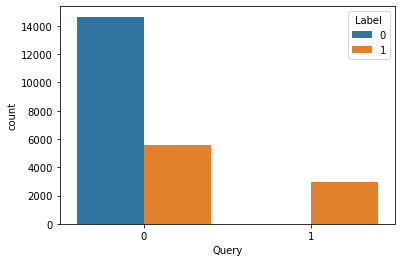

In [17]:
sns.countplot(hue = y_train, x = single_line_comments)
plt.show()

This is an important feature as the presence of single line comment itself denotes that the query is harmful. Which makes sense as the use of single line comments by developers while querying the database is uncommon. Therefore, should be retained.

In [18]:
#count of multiline comments
def multiline_comment(x):
    return len(re.findall('\/\*', x))
gm
multiline_comments = X_train.apply(multiline_comment)

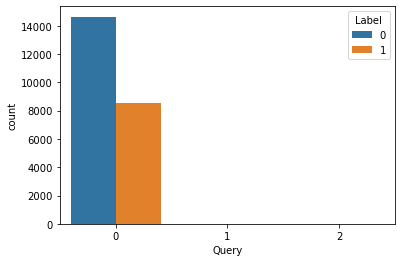

In [19]:
sns.countplot(hue = y_train, x = multiline_comments)
plt.show()

This feature can be discarded as there aren't many queries with multiline comments. Hence, won't be useful in distinguishing queries.

In [20]:
#count of logical operators (and, not, nor, or, ||, &&, and !) in the queries
def logical_operators(x):
    return len(re.findall("\snot\s|\sand\s|\sor\s|\sxor\s|&&|\|\||!", x))

logical_operators_cnt = X_train.apply(logical_operators)

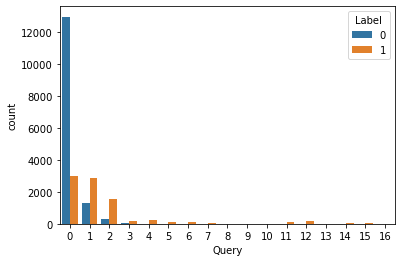

In [21]:
sns.countplot(hue = y_train, x = logical_operators_cnt)
plt.show()

If the no of logical operators are more than 4, then we can for sure say the query is malicious. In general, injection queries have more no of logical operators than normal queries. This feature should be retained.

In [22]:
#looking for the no of occurrences of keywords assumed to be harmful - delete, drop, add, modify, union
def find_modify(x):
    return len(re.findall('\smodify\s', x))

cnt_modify = X_train.apply(find_modify)

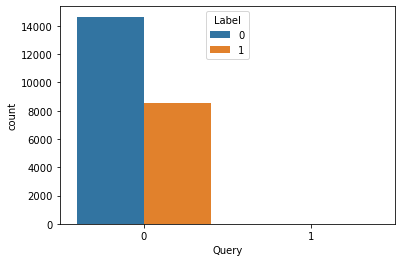

In [23]:
sns.countplot(hue = y_train, x = cnt_modify)
plt.show()

This feature is not useful as it doesn't occur much in queries as part of this dataset.

In [24]:
def find_delete(x):
    return len(re.findall('\sdelete\s', x))

cnt_delete = X_train.apply(find_delete)

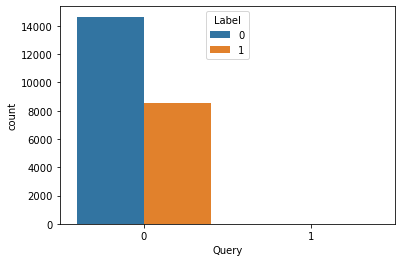

In [25]:
sns.countplot(hue = y_train, x = cnt_delete)
plt.show()

This feature also won't be useful.

In [26]:
def find_drop(x):
    return len(re.findall('\sdrop\s', x))

cnt_drop = X_train.apply(find_drop)

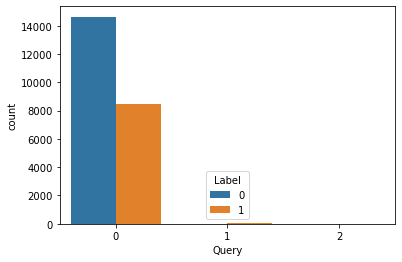

In [27]:
sns.countplot(hue = y_train, x = cnt_drop)
plt.show()

This feature can be retained though the no. of occurences are less, because it's presence for sure indicates that the query is malicious.

In [28]:
def find_add(x):
    return len(re.findall('\sadd\s', x))

cnt_add = X_train.apply(find_add)

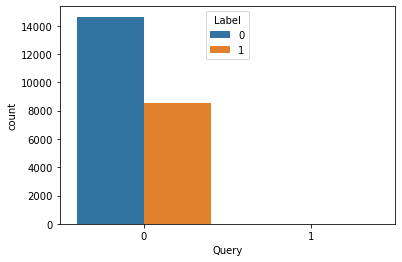

In [29]:
sns.countplot(hue = y_train, x = cnt_add)
plt.show()

This feature isn't useful in distinguishing queries, can be discarded.

In [30]:
def find_union(x):
    return len(re.findall('\sunion\s', x))

cnt_union = X_train.apply(find_union)

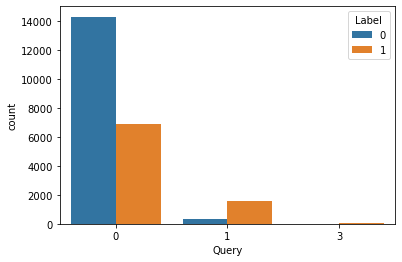

In [31]:
sns.countplot(hue = y_train, x = cnt_union)
plt.show()

Even though there is significant overlap. In general, as the count of union increases there is higher chance that the query is an injection query. This feature should be retained.

In [32]:
#count of dangerous special characters like @, %, ?, and ^
def special_chars(x):
    return len(re.findall("\@|\%|\?|\^", x))

cnt_special_chars = X_train.apply(special_chars)

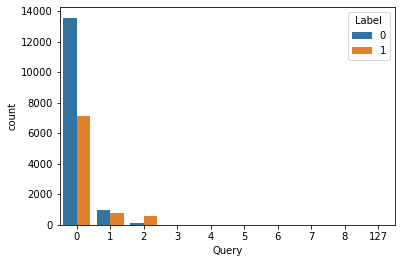

In [33]:
sns.countplot(hue = y_train, x = cnt_special_chars)
plt.show()

There is a significant overlap in this case. This feature though can't be completely disregarded.

In [34]:
def equal(x):
    return len(re.findall("=", x))

cnt_equal = X_train.apply(equal)

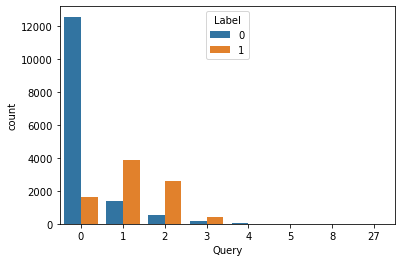

In [35]:
sns.countplot(hue = y_train, x = cnt_equal)
plt.show()

In [36]:
def double_equal(x):
    return len(re.findall("==", x))

cnt_double_equal = X_train.apply(double_equal)

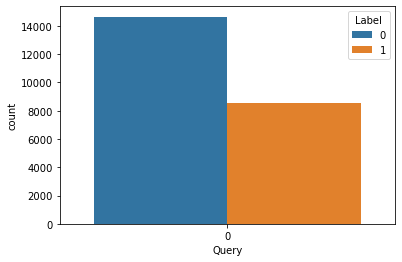

In [37]:
sns.countplot(hue = y_train, x = cnt_double_equal)
plt.show()

Even with some overlap, as the no of equal signs is more the query there is higher chance of the query being harmful. There are no == sign in this data so, we don't have to take care of that while calculating count of =.

In [38]:
#count of delimiters i.e., ;

def delimiter(x):
    return len(re.findall(';', x))

cnt_delimiter = X_train.apply(delimiter)

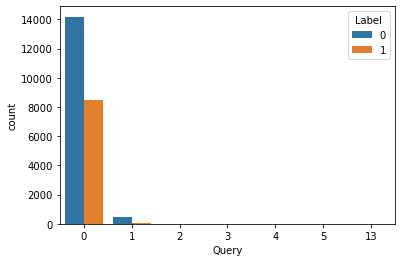

In [39]:
sns.countplot(hue = y_train, x = cnt_delimiter)
plt.show()

In [40]:
def dot(x):
    return len(re.findall('.', x))

cnt_dot = X_train.apply(dot)

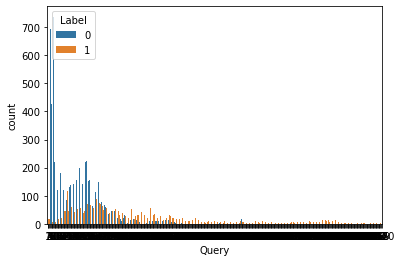

In [41]:
sns.countplot(hue = y_train, x = cnt_dot)
plt.show()

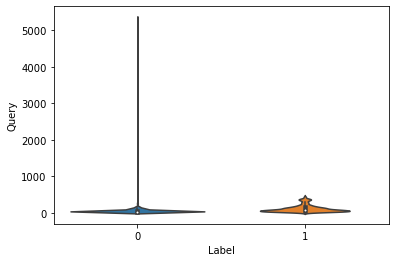

In [42]:
sns.violinplot(x = y_train, y = cnt_dot)
plt.show()

As the count of dot increases the probability of the query being harmful also sees a rise.

In [43]:
#getting the count of all arithmetic operators used in the query
def arithmetic_operators(x):
    return len(re.findall("\+|-|\\|\*", x))

cnt_arithmetic_operators = X_train.apply(arithmetic_operators)

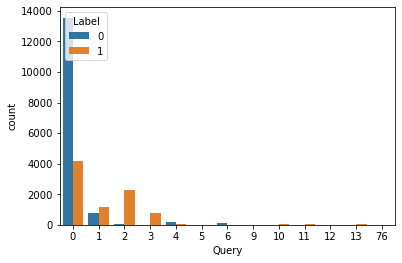

In [44]:
sns.countplot(hue = y_train, x = cnt_arithmetic_operators)
plt.show()

In general if there are more arithmetic operators, the query is malicious. Still, there is some scope of doubt here as there some overlap.

In [45]:
#no of whitespaces
def whitespaces(x):
    return len(re.findall("\s", x))

cnt_whitespaces = X_train.apply(whitespaces)

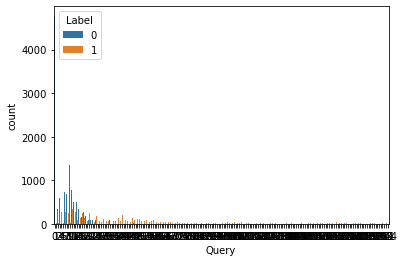

In [46]:
sns.countplot(hue = y_train, x = cnt_whitespaces)
plt.show()

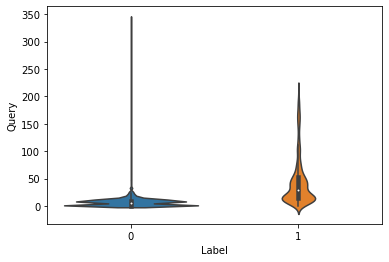

In [47]:
sns.violinplot(x = y_train, y = cnt_whitespaces)
plt.show()

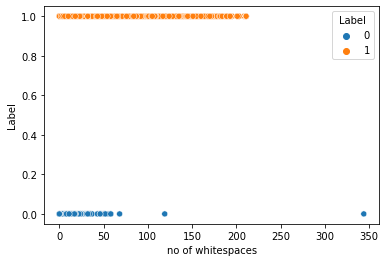

In [48]:
sns.scatterplot(x = cnt_whitespaces, y = y_train, hue = y_train)
plt.xlabel('no of whitespaces')
plt.show()

General conscience is that more the no of whites spaces higher the chance that the query is an injection query. This feature should be retained.

In [49]:
#no of digits
def digits(x):
    return len(re.findall("[0-9]", x))

cnt_digits = X_train.apply(digits)

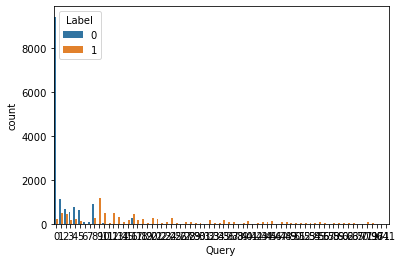

In [50]:
sns.countplot(hue = y_train, x = cnt_digits)
plt.show()

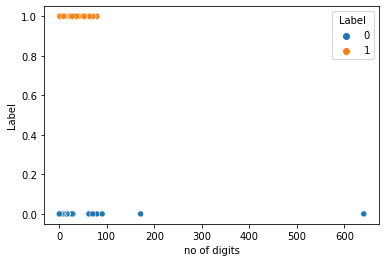

In [51]:
sns.scatterplot(x = cnt_digits, y = y_train, hue = y_train)
plt.xlabel('no of digits')
plt.show()

There is quite some overlap. It is difficult to come to a conclusion about this feature.

In [52]:
#no of alphabets
def alphabets(x):
    return len(re.findall("[a-z]", x))

cnt_alphabets = X_train.apply(alphabets)

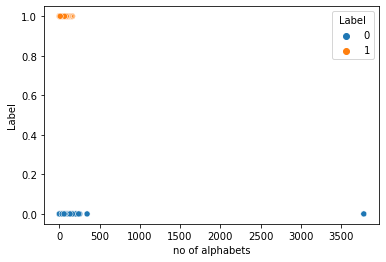

In [53]:
sns.scatterplot(x = cnt_alphabets, y = y_train, hue = y_train)
plt.xlabel('no of alphabets')
plt.show()

There is quite some overlap. It is difficult to come to a conclusion about this feature.

In [54]:
#count of brackets (), []
def brackets(x):
    return len(re.findall("\(|\)|\[|\]", x))

cnt_brackets = X_train.apply(brackets)

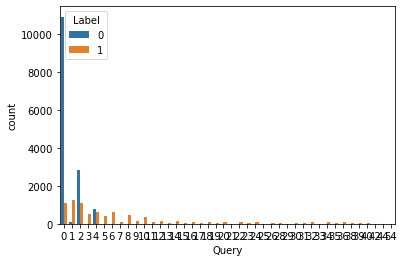

In [55]:
sns.countplot(hue = y_train, x = cnt_brackets)
plt.show()

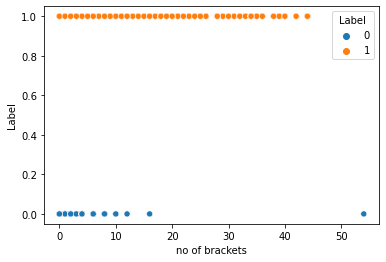

In [56]:
sns.scatterplot(x = cnt_brackets, y = y_train, hue = y_train)
plt.xlabel('no of brackets')
plt.show()

This feature will be useful in distinguishing queries and should be retained.

In [57]:
#count of null values in the query
def nulls(x):
    return len(re.findall("null", x))

cnt_nulls = X_train.apply(nulls)

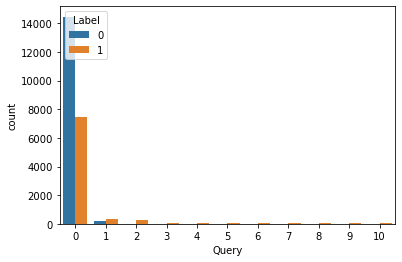

In [58]:
sns.countplot(hue = y_train, x = cnt_nulls)
plt.show()

If there are 2 or more null values in the query then it is an injection query. Feature will come handy.

In [59]:
#count of hexadecimal values
#reference: https://stackoverflow.com/questions/9221362/regular-expression-for-a-hexadecimal-number
def hexadecimal(x):
    return len(re.findall("0[xX][0-9a-f]+", x))

cnt_hexadecimal = X_train.apply(hexadecimal)

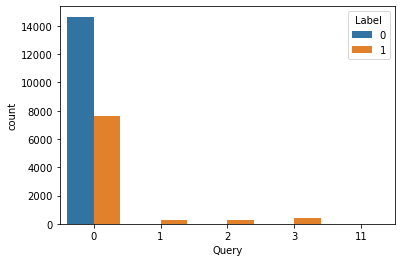

In [60]:
sns.countplot(hue = y_train, x = cnt_hexadecimal)
plt.show()

Presence of hexadecimal values denotes that the query is an injection query. This feature should be used while modelling.

In [61]:
#count of commas
def commas(x):
    return len(re.findall(",", x))

cnt_commas = X_train.apply(commas)

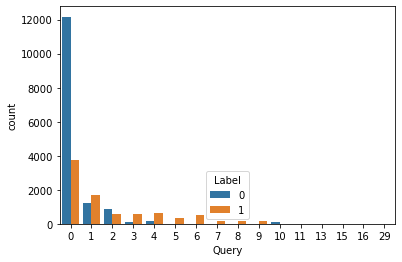

In [62]:
sns.countplot(hue = y_train, x = cnt_commas)
plt.show()

There is some overlap but still the feature can be used for modelling. More the no of commas higher the chance that it is an inejction query.

In [63]:
#count of single quotes
def single_quotes(x):
    return len(re.findall("\'\'", x))

cnt_single_quotes = X_train.apply(single_quotes)

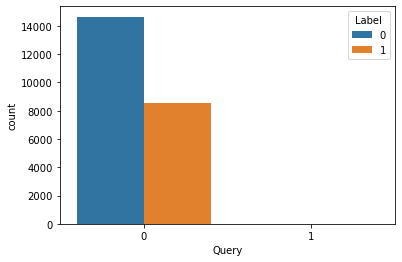

In [64]:
sns.countplot(hue = y_train, x = cnt_single_quotes)
plt.show()

Feature can be discarded.

In [65]:
#count of single quotes
def single_quotes_with_gaps(x):
    return len(re.findall("\'", x))

cnt_single_quotes_with_gaps = X_train.apply(single_quotes_with_gaps)

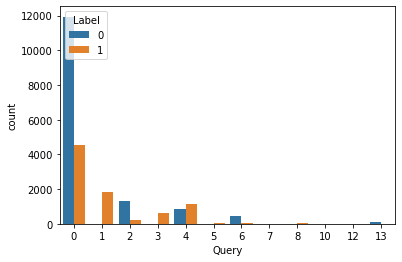

In [66]:
sns.countplot(hue = y_train, x = cnt_single_quotes_with_gaps)
plt.show()

There is some overlap but can be retained for modelling.

In [67]:
#count of double quotes
def double_quotes(x):
    return len(re.findall('\"\"', x))

cnt_double_quotes = X_train.apply(double_quotes)

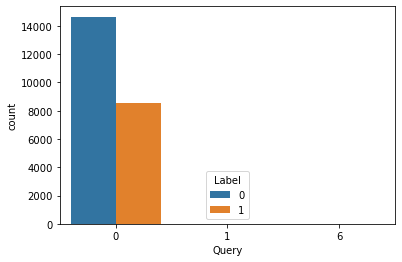

In [68]:
sns.countplot(hue = y_train, x = cnt_double_quotes)
plt.show()

This feature can be discarded.

In [69]:
def double_quotes_with_gaps(x):
    return len(re.findall('\"', x))

cnt_double_quotes_with_gaps = X_train.apply(double_quotes_with_gaps)

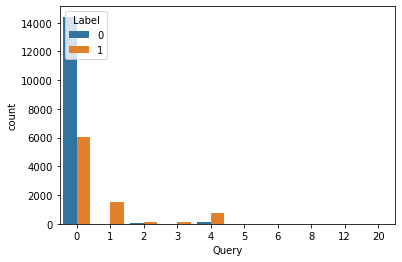

In [70]:
sns.countplot(hue = y_train, x = cnt_double_quotes_with_gaps)
plt.show()

This feature is useful in distinguishing queries. It's presence increases the chance of teh query being an injection query.

Conclusion:-
    
    1. All the features that helped in segregating queries to even some extent have been retained/ extracted.
    
    2. We will perform BoW, Tfidf on the queries to after tokenizing them. The reference papers have used BoW, but we will try Tfidf as well to see which one gives better results.
    
    3. All special characters will be lost when we perform any of the above two. Hence, to take them into consideration we have extfracted them before hand here as they are significant to our analysis.

### We will now proceed with preprocessing the data. To create train.csv and test.csv, such both the datasets have all the features extracted above that we plan to retain.


In [83]:
def preprocess_data(x):
    features = {}
    features['single_comments'] = single_comments(x)
    features['logical_operators'] = logical_operators(x)
    features['arithmetic_operators'] = arithmetic_operators(x)
    features['drop'] = find_drop(x)
    features['union'] = find_union(x)
    features['special_chars']  = special_chars(x)
    features['equal']  = equal(x)
    features['delimiter'] = delimiter(x)
    features['dot'] = dot(x)
    features['whitespaces'] = whitespaces(x)
    features['digits'] = digits(x)
    features['alphabets'] = alphabets(x)
    features['brackets'] = brackets(x)
    features['nulls'] = nulls(x)
    features['hexadecimal'] = hexadecimal(x)
    features['commas'] = commas(x)
    features['single_quotes'] = single_quotes_with_gaps(x)
    features['double_quotes'] = double_quotes_with_gaps(x)
    
    return features

In [88]:
train_data = pd.concat([X_train,X_train.apply(preprocess_data).apply(pd.Series)], axis = 1)

In [93]:
preprocessed_train = pd.concat([train_data, y_train], axis = 1)

In [91]:
X_train.shape

(23171,)

In [94]:
preprocessed_train.shape

(23171, 20)

In [95]:
preprocessed_train.head()

,Query,single_comments,logical_operators,arithmetic_operators,drop,union,special_chars,equal,delimiter,dot,whitespaces,digits,alphabets,brackets,nulls,hexadecimal,commas,single_quotes,double_quotes,Label
7768,"1%' and 6055 = ctxsys.drithsx.sn ( 6055, ...",0,12,0,0,0,2,3,0,343,148,49,84,30,0,0,1,4,0,1
14655,piedramillera,0,0,0,0,0,0,0,0,13,0,0,13,0,0,0,0,0,0,0
19535,select wp_posts.* from wp_posts where id in (...,0,0,0,0,0,0,0,0,56,11,6,33,2,0,0,0,0,0,0
2239,select count ( * ) from domain.domains as...,0,1,0,0,0,0,0,0,117,25,3,77,3,0,0,2,0,3,1
10007,call regexp_substring ( repeat ( left ( ...,0,3,0,0,0,0,1,0,175,63,16,68,14,2,0,4,3,0,1


In [96]:
test_data = pd.concat([X_test,X_test.apply(preprocess_data).apply(pd.Series)], axis = 1)

In [97]:
preprocessed_test = pd.concat([test_data, y_test], axis = 1)

In [98]:
test_data.shape

(7730, 19)

In [99]:
X_test.shape

(7730,)

In [100]:
preprocessed_test.shape

(7730, 20)

In [101]:
preprocessed_train.to_csv('preprocessed_train.csv',index = False)
preprocessed_test.to_csv('preprocessed_test.csv',index = False)